# Codificación superdensa

## Diferencias entre Teleportación cuántica y Codificación superdensa

Teleportación cuántica es el proceso por el cual un estado (|ψ⟩) puede ser transmitido de un lugar a otro usando dos bits clasicos y un par Bell. La codificación superdensa trata de un proceso que permite enviar dos bits clasicos atraves de un solo qubit de comunicación.

### Quiskit

En este apartado se expone como implementar un circuito de codificación superdensa en qiskit y a partir de el poder enviar dos bits cualesquiera ayudandonos de dicho circuito.

In [11]:
from qiskit import QuantumCircuit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram

Creamos el par de Bell para entrelazar los qubits entre si

In [2]:
def create_bell_pair(qc, a, b):
    qc.h(a) # Aplicamos una Hadamard a 'a'
    qc.cx(a,b) # Aplicamos una cnot a 'b' 
               # usando 'a' como qubit de control

Esta funcion pasa recive el mensaje que se quiere enviar y aplica las puertas necesarias al qubit dado (que en este caso sera el qubit al que se aplica le hadamard en el par de Bell al inicio del circuito) para que este pueda transmitir el mensaje de dos bits.

In [3]:
def encode_message(qc, qubit, msg):
    if msg == "00":
        pass    # Nada para mandar 00
    elif msg == "10":
        qc.x(qubit) # Puerta X para mandar 10
    elif msg == "01":
        qc.z(qubit) # Puerta Z para mandar 01
    elif msg == "11":
        qc.z(qubit) # Puerta Z para mandar 11
        qc.x(qubit) # sequida de una puerta X
    else:
        print("Invalid Message: Sending '00'")

Esta función sera la encargada de una vez llegado el qubit que contiene la información de ambos bits enviados y utilizando el segundo qubit del par de bell entrelazado al principio de circuito, recrear el mensaje de dos bits clasicos que se querian enviar.

In [4]:
def decode_message(qc, a, b):
    qc.cx(a,b)
    qc.h(a)

Creamos el circuito usando todas las funciones anteriores

In [5]:
qc = QuantumCircuit(2)


# Primero, creamos un par entrelazado de qubits
create_bell_pair(qc, 0, 1)
qc.barrier()

# Uno va a emisor y otro al receptor de los dos bits clasicos

# Ahora codificamos el mensaje en q0, en este caso hemos utilizado el 
# mensaje '10' , lo que nos es indiferente ya que cualquier mensaje 
# de dos podría ser mandado
message = "10"
encode_message(qc, 0, message)
qc.barrier()
# Enviamos el qubit al receptor

# Decodificamos el qubit que nos han 
# mandado con la información del mensaje
decode_message(qc, 0, 1)

qc.measure_all()

qc.draw()

┌───┐      ░ ┌───┐ ░      ┌───┐ ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤ X ├─░───■──┤ H ├─░─┤M├───
        └───┘┌─┴─┐ ░ └───┘ ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░───────░─┤ X ├──────░──╫─┤M├
             └───┘ ░       ░ └───┘      ░  ║ └╥┘
meas: 2/═══════════════════════════════════╩══╩═
                                           0  1

Como podemos observar en la siguiente simulacion, los datos que nos salen al medir son siempre iguales al mensaje enviado, y esto pasa siempre ya que lo estamos midiendo en condiciones ideales

{'10': 1024}


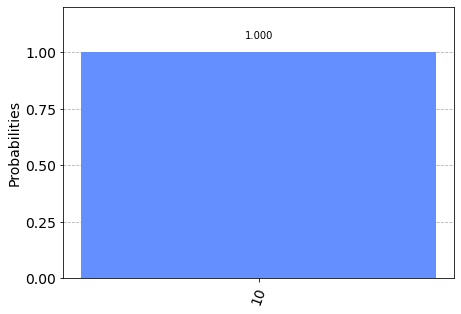

In [6]:
qasm_sim = Aer.get_backend('qasm_simulator')
qobj = assemble(qc)
result = qasm_sim.run(qobj).result()
counts = result.get_counts(qc)
print(counts)
plot_histogram(counts)

## Simulacion en condiciones no ideales

### Ejecucion con modelos de ruido

In [7]:
from qiskit import QuantumCircuit, execute
from qiskit import IBMQ, Aer
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel
from qiskit.compiler import transpile, assemble, schedule
IBMQ.save_account('your account', overwrite=True)
provider = IBMQ.load_account()

/home/feynman/anaconda3/envs/qiskitEnv/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '



Número de ocurrencias: {'00': 46, '01': 4, '10': 939, '11': 35}


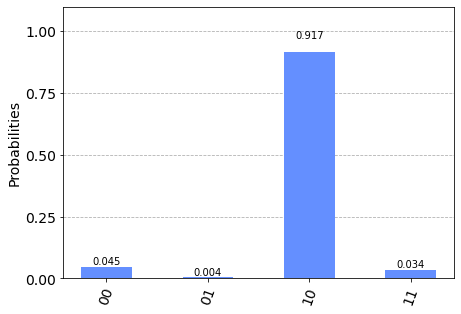

In [10]:
# Construir un modelo de ruido a partir de las características de un backend real
backend = provider.get_backend('ibmq_belem')
noise_model = NoiseModel.from_backend(backend)

# Obtener el mapa de interconexión de los qubits
coupling_map = backend.configuration().coupling_map

# Obtener las características de las puertas básicas
basis_gates = noise_model.basis_gates

######################
# Crear circuito    #
#####################

# Perform a noise simulation
result = execute(qc, Aer.get_backend('qasm_simulator'),
                 coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model).result()

######################
# Mostrar resultados #
######################

counts = result.get_counts(qc)
print("\nNúmero de ocurrencias:",counts)
plot_histogram(counts)

Como podemos ver aunque '10' (el mensaje que queremos enviar) no es siempre la salida, la probabilidad de que ocurra es lo suficientemente mayor como para considerarse un exito, teniendo un fallo de solo el 8,5%.

### Ejecucion en backends reales

In [14]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
shots = 1024

IBMQ.load_account()
# Get the least busy backend
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 and not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

t_qc = transpile(qc, backend, optimization_level=3)
qobj = assemble(t_qc)
job = backend.run(qobj)

/home/feynman/anaconda3/envs/qiskitEnv/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


least busy backend:  ibmq_belem


In [18]:
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


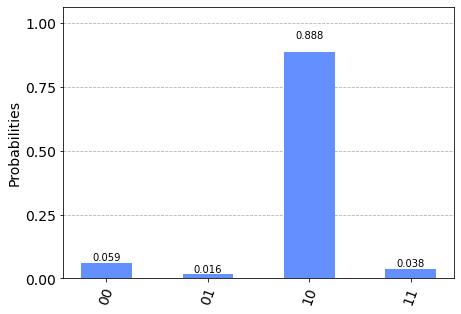

In [19]:
result = job.result()
plot_histogram(result.get_counts(qc))

In [20]:
correct_results = result.get_counts(qc)[message]
accuracy = (correct_results/shots)*100
print(f"Accuracy = {accuracy:.2f}%")

Accuracy = 88.77%


Vemos que el error no es nulo, la tasa de fallos del experimento es de un 11,23% que aunq para ordenadores que deberian trabajar con miles de operaciones aun es mucho es suficiente como para considerarlo un exito.

### Conclusiones

Como ya vimos en la practica anterior los resultados no son siempre los esperados debido a la existencia de ruido por lo que no siempre funcionara el circuito, lo que podemos ver en el ultimo apartado de una ejecucion en backend real ya que esta tasa de fallo supera el 10%.

En cuanto a las diferencias entre la simulacion con ruido y la ejecucion en un ordenador cuantico podemos observar que en el backend real existe una probabilidad mas grande de fallo ya que la suma de las probabilidades de los estados fallidos es 0.085 en la simulación y en el backend real es de 0.1123, que aun no siendo el doble como ocurria en la teleportación cuantica, esta tasa de fallos es muy grande para un ordenador.